In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt

data = xr.open_dataset("../data/delhi_cpcb_2022.nc")
data

<xarray.Dataset>
Dimensions:    (station: 40, time: 8783)
Coordinates:
  * station    (station) object 'Alipur, Delhi - DPCC' ... 'Wazirpur, Delhi -...
  * time       (time) datetime64[ns] 2022-01-01T00:30:00 ... 2023-01-01T22:23:30
    latitude   (station) float64 ...
    longitude  (station) float64 ...
Data variables: (12/21)
    From Date  (station, time) datetime64[ns] ...
    To Date    (station, time) datetime64[ns] ...
    PM2.5      (station, time) float64 ...
    PM10       (station, time) float64 ...
    NO         (station, time) float64 ...
    NO2        (station, time) float64 ...
    ...         ...
    WD         (station, time) float64 ...
    SR         (station, time) float64 ...
    BP         (station, time) float64 ...
    AT         (station, time) float64 ...
    RF         (station, time) float64 ...
    TOT-RF     (station, time) float64 ...

In [2]:
df = data.to_dataframe()
# df = df["2022-01-01": "2022-12-31"]
df = data.to_dataframe().reset_index()
df = df[df["time"]=="2022-03-01 01:30:00"]
df = df.dropna(subset=["PM2.5"])
df = df.rename(columns={"RH": "relative_humidity", "WS": "wind_speed", "WD": "wind_direction", "SR": "solar_radiation", "BP": "pressure", "AT": "temperature", "RF": "rain_fall", "TOT-RF": "total_rainfall"})

In [3]:
len(df)

39

In [4]:
df.head()

,station,time,From Date,To Date,PM2.5,PM10,NO,NO2,NOx,NH3,...,relative_humidity,wind_speed,wind_direction,solar_radiation,pressure,temperature,rain_fall,total_rainfall,latitude,longitude
1417,"Alipur, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,70.00,150.0,3.78,43.38,26.15,3.42,...,78.22,NaN,139.97,4.55,993.40,11.43,0.0,0.0,28.815329,77.153010
10200,"Anand Vihar, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,52.50,144.0,11.88,30.62,26.02,15.82,...,68.95,0.30,246.25,8.95,973.65,15.45,NaN,0.0,28.647622,77.315809
18983,"Ashok Vihar, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,79.00,134.0,7.47,67.17,41.80,50.77,...,71.30,0.38,206.90,5.43,987.17,13.82,0.0,0.0,28.695381,77.181665
27766,"Aya Nagar, Delhi - IMD",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,73.94,159.3,22.49,26.28,48.80,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,28.470691,77.109936
36549,"Bawana, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,135.00,245.0,4.80,20.65,25.43,41.45,...,81.62,0.62,22.33,5.70,993.12,12.30,0.0,0.0,28.776200,77.051074


In [209]:
import networkx as nx
import math

# Define the distance threshold (in kilometers)
distance_threshold = 12

# Create an empty nx graph
G = nx.Graph()

# Iterate through each node in the dataset
for i in range(len(df)):
    lat1, lon1 = df.iloc[i]['latitude'], df.iloc[i]['longitude']
    pm = df.iloc[i]['PM2.5']
    
    # Add the current node to the nx graph
    G.add_node(i, latitude=lat1, longitude=lon1, pm=pm)

    # Iterate through the remaining nodes
    for j in range(i + 1, len(df)):
        lat2, lon2 = df.iloc[j]['latitude'], df.iloc[j]['longitude']
        
        # Calculate the distance between the coordinates using the Haversine formula
        radius = 6371  # Earth's radius in kilometers
        dlat = math.radians(lat2 - lat1)
        dlon = math.radians(lon2 - lon1)
        a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        distance = radius * c
        
        # Check if the distance is below the threshold
        if distance <= distance_threshold:
            # Add an edge between the current pair of nodes in the nx graph
            G.add_edge(i, j)

# Now you have the nx graph where nodes represent the data points with latitude and longitude as features, and edges represent nodes within the distance threshold


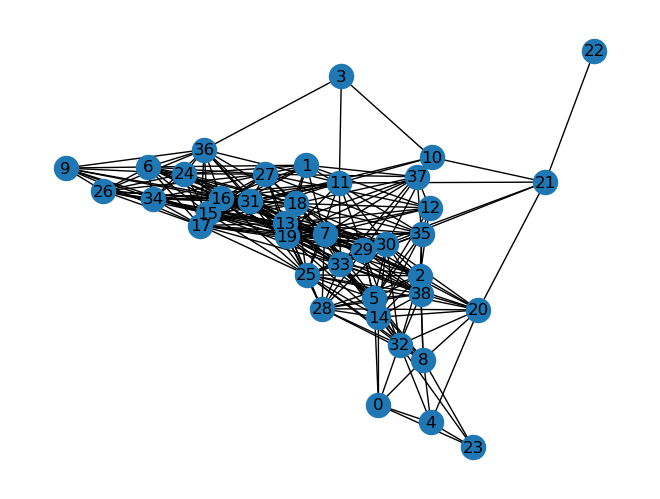

In [210]:
layout = nx.spring_layout(G, k=0.5)

# Draw the graph with the specified layout
nx.draw(G, pos=layout, with_labels=True)


In [211]:
import folium
import networkx as nx
from folium.plugins import FastMarkerCluster

# Create a NetworkX graph (G) and calculate node positions (lat_lon_dict)
lat_lon_dict = {}
for node in G.nodes:
    lat_lon_dict[node] = (G.nodes[node]['latitude'], G.nodes[node]['longitude'])

# Create a Folium map centered on Delhi
m = folium.Map(location=[28.7041, 77.1025], zoom_start=10)

# Create a MarkerCluster layer for better performance
marker_cluster = FastMarkerCluster(data=list(lat_lon_dict.values()))
m.add_child(marker_cluster)

# Iterate over the edges and add them to the map as lines
for u, v in G.edges:
    lat1, lon1 = lat_lon_dict[u]
    lat2, lon2 = lat_lon_dict[v]
    folium.PolyLine([(lat1, lon1), (lat2, lon2)], color='gray', weight=1).add_to(m)

# Iterate over the nodes and add them to the map as markers
for node, (lat, lon) in lat_lon_dict.items():
    folium.CircleMarker(location=(lat, lon), radius=5, color='blue', fill=True, fill_color='blue').add_to(m)

# Display the map
m


In [185]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv

node_features = [(G.nodes[node]['latitude'], G.nodes[node]['longitude']) for node in G.nodes]
edge_index = torch.tensor(list(G.edges)).t().contiguous()
y = torch.tensor([G.nodes[node]['pm'] for node in G.nodes], dtype=torch.float).view(-1, 1)
train_mask = torch.zeros(y.size(0), dtype=torch.bool)
test_mask = torch.zeros(y.size(0), dtype=torch.bool)
train_mask[:25] = True
test_mask[25:] = True

data = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, y=y,train_mask=train_mask, test_mask=test_mask)

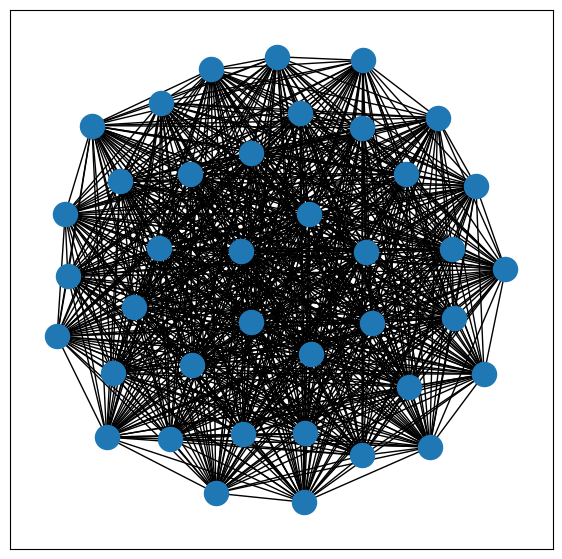

In [186]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,)
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()
    
G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [187]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.conv1 = GCNConv(input_dim, 16)
        self.conv2 = GCNConv(16, 10)
        self.linear1 = nn.Linear(10, 10)
        self.linear2 = nn.Linear(10, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x


In [188]:
import random
seed = 42
random.seed(seed)
torch.manual_seed(seed)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RegressionModel(input_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [189]:
train_rmse_list = []
test_rmse_list = []

In [190]:


from tqdm import tqdm


for epoch in tqdm(range(2500)):
    optimizer.zero_grad()
    out = model(data.x.to(device), data.edge_index.to(device))
    loss = criterion(out[data.train_mask].squeeze(), data.y[data.train_mask].squeeze())
    loss.backward()
    optimizer.step()
    if(epoch%100==0):
        model.eval()
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
            train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
            test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
            train_rmse_list.append(train_rmse.item())
            test_rmse_list.append(test_rmse.item())
        model.train()



100%|██████████| 2500/2500 [00:02<00:00, 1165.06it/s]


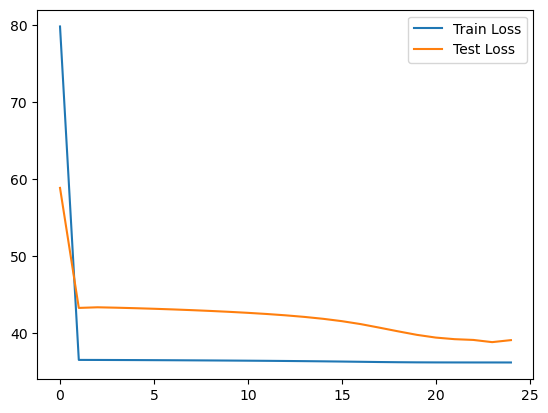

In [191]:
import matplotlib.pyplot as plt

# Assuming you have train_loss_list and test_loss_list as lists containing the respective losses

# Plotting train loss
plt.plot(range(len(train_rmse_list)), train_rmse_list, label='Train Loss')



# Plotting test loss
plt.plot(range(len(test_rmse_list)), test_rmse_list, label='Test Loss')

plt.legend()
plt.show()

In [192]:
model.eval()
with torch.no_grad():
    out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
    train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
    test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
    print(f"GNN train rmse:{train_rmse}")
    print(f"GNN test rmse: {test_rmse}")

GNN train rmse:36.22104263305664
GNN test rmse: 39.094364166259766


In [193]:
len(data.x[data.train_mask].numpy())

25

In [194]:
from sklearn.ensemble import RandomForestRegressor

# Step 1: Prepare the data
X_train = data.x[data.train_mask].numpy()
y_train = data.y[data.train_mask].numpy().reshape(-1)
X_test = data.x[data.test_mask].numpy()
y_test = data.y[data.test_mask].numpy().reshape(-1)

# Step 2: Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(X_train, y_train)

# Step 3: Make predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Step 4: Evaluate the model
train_rmse = torch.sqrt(torch.mean((torch.tensor(y_train_pred) - data.y[data.train_mask])**2))
test_rmse = torch.sqrt(torch.mean((torch.tensor(y_test_pred) - data.y[data.test_mask])**2))

print('Train RMSE:', train_rmse.item())
print('Test RMSE:', test_rmse.item())


Train RMSE: 45.30544851018116
Test RMSE: 28.380060809112642


In [195]:
len(y_test_pred)

14

In [196]:
y_test = data.y[data.test_mask].squeeze().cpu().numpy()
y_test

array([ 22.41,  83.  ,  75.  , 113.  , 103.  ,  59.72,  90.  , 124.67,
        51.62,  77.5 ,  55.  ,  63.  ,  58.5 ,  94.  ], dtype=float32)

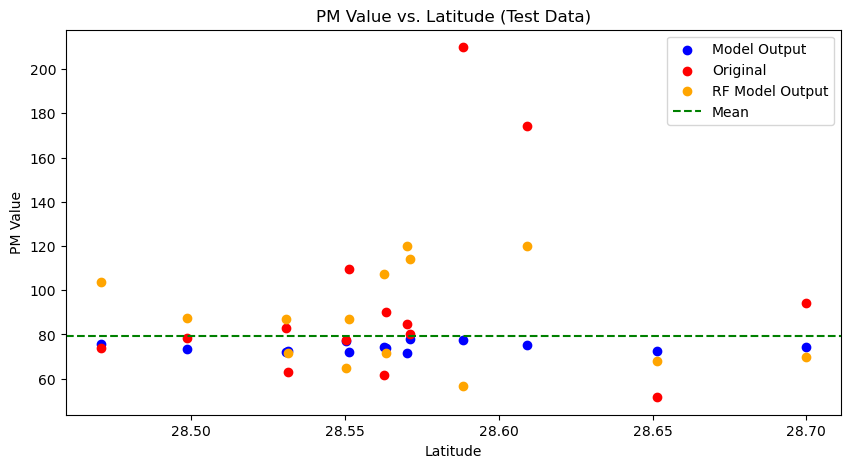

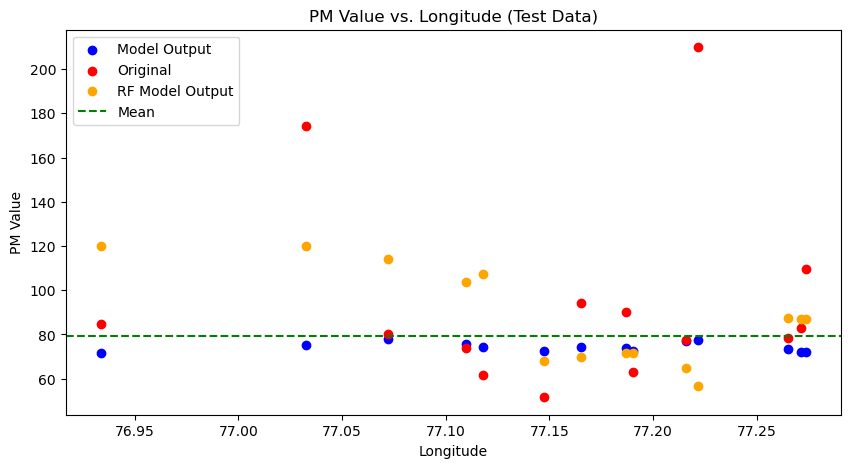

In [156]:
import matplotlib.pyplot as plt
# Get the output of the model and original y values for test data
with torch.no_grad():
    out_test = model(data.x.to(device), data.edge_index.to(device))[data.test_mask].squeeze()
y_test = data.y[data.test_mask].squeeze().cpu().numpy()

# Get the latitude and longitude for test data
lat_test = data.x[data.test_mask][:, 0].cpu().numpy()
lon_test = data.x[data.test_mask][:, 1].cpu().numpy()
train_mean = torch.mean(data.y[data.train_mask])
# Plot the model output against latitude and longitude
plt.figure(figsize=(10, 5))
plt.scatter(lat_test, out_test.cpu().numpy(), c='b', label='Model Output')
plt.scatter(lat_test, y_test, c='r', label='Original')
plt.scatter(lat_test, y_test_pred, c='orange', label='RF Model Output')
plt.axhline(train_mean, c='g', linestyle='--', label='Mean')
plt.xlabel('Latitude')
plt.ylabel('PM Value')
plt.title('PM Value vs. Latitude (Test Data)')
plt.legend()
plt.show()


# Plot the model output against latitude and longitude
plt.figure(figsize=(10, 5))
plt.scatter(lon_test, out_test.cpu().numpy(), c='b', label='Model Output')
plt.scatter(lon_test, y_test, c='r', label='Original')
plt.scatter(lon_test, y_test_pred, c='orange', label='RF Model Output')
plt.axhline(train_mean, c='g', linestyle='--', label='Mean')
plt.xlabel('Longitude')
plt.ylabel('PM Value')
plt.title('PM Value vs. Longitude (Test Data)')
plt.legend()
plt.show()



/var/folders/jk/w0z8m7r15qz2bq604dfvr16h0000gn/T/ipykernel_63754/3893041432.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(data.x[data.train_mask].numpy(), data.y[data.train_mask].numpy())


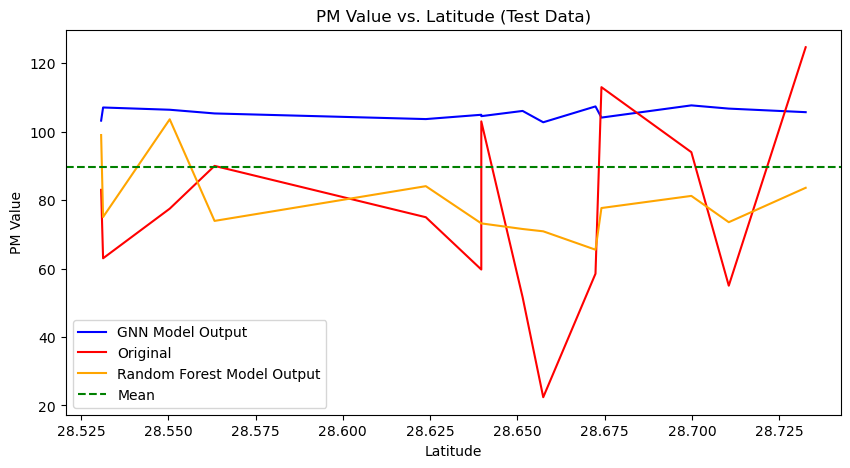

In [134]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(data.x[data.train_mask].numpy(), data.y[data.train_mask].numpy())

# Use the Random Forest model to predict y values for the test data
y_test_pred_rf = rf_model.predict(data.x[data.test_mask].numpy())

# Get the output of the GNN model and original y values for the test data
with torch.no_grad():
    out_test = model(data.x.to(device), data.edge_index.to(device))[data.test_mask].squeeze()
y_test = data.y[data.test_mask].squeeze().cpu().numpy()

# Get the latitude, longitude, and y values for the test data
lat_test = data.x[data.test_mask][:, 0].cpu().numpy()
lon_test = data.x[data.test_mask][:, 1].cpu().numpy()

# Sort the latitude, longitude, and y values together based on latitude
lat_lon_y = sorted(zip(lat_test, lon_test, y_test, out_test.cpu().numpy(), y_test_pred_rf))
lat_test, lon_test, y_test, out_test_sorted, y_test_pred_rf_sorted = zip(*lat_lon_y)

# Calculate the mean value for the train data
train_mean = torch.mean(data.y[data.train_mask]).item()

# Plot the GNN model output, Random Forest model output, and original y values against latitude
plt.figure(figsize=(10, 5))
plt.plot(lat_test, out_test_sorted, c='b', label='GNN Model Output')
plt.plot(lat_test, y_test, c='r', label='Original')
plt.plot(lat_test, y_test_pred_rf_sorted, c='orange', label='Random Forest Model Output')
plt.axhline(train_mean, c='g', linestyle='--', label='Mean')
plt.xlabel('Latitude')
plt.ylabel('PM Value')
plt.title('PM Value vs. Latitude (Test Data)')
plt.legend()
plt.show()



/var/folders/jk/w0z8m7r15qz2bq604dfvr16h0000gn/T/ipykernel_63754/1858052209.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(data.x[data.train_mask].numpy(), data.y[data.train_mask].numpy())


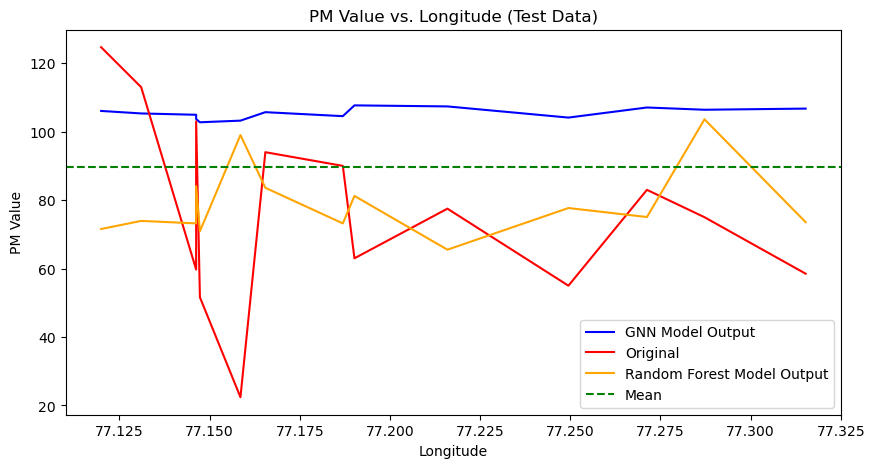

In [135]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(data.x[data.train_mask].numpy(), data.y[data.train_mask].numpy())

# Use the Random Forest model to predict y values for the test data
y_test_pred_rf = rf_model.predict(data.x[data.test_mask].numpy())

# Get the output of the GNN model and original y values for the test data
with torch.no_grad():
    out_test = model(data.x.to(device), data.edge_index.to(device))[data.test_mask].squeeze()
y_test = data.y[data.test_mask].squeeze().cpu().numpy()

# Get the latitude, longitude, and y values for the test data
lat_test = data.x[data.test_mask][:, 0].cpu().numpy()
lon_test = data.x[data.test_mask][:, 1].cpu().numpy()

# Sort the latitude, longitude, and y values together based on latitude
lon_lat_y = sorted(zip(lon_test, lat_test, y_test, out_test_sorted, y_test_pred_rf_sorted))
lon_test, lat_test, y_test, out_test_sorted, y_test_pred_rf_sorted = zip(*lon_lat_y)


# Calculate the mean value for the train data
train_mean = torch.mean(data.y[data.train_mask]).item()

# Plot the GNN model output, Random Forest model output, and original y values against longitude
plt.figure(figsize=(10, 5))
plt.plot(lon_test, out_test_sorted, c='b', label='GNN Model Output')
plt.plot(lon_test, y_test, c='r', label='Original')
plt.plot(lon_test, y_test_pred_rf_sorted, c='orange', label='Random Forest Model Output')
plt.axhline(train_mean, c='g', linestyle='--', label='Mean')
plt.xlabel('Longitude')
plt.ylabel('PM Value')
plt.title('PM Value vs. Longitude (Test Data)')
plt.legend()
plt.show()


In [83]:
train_mean = torch.mean(data.y[data.train_mask])
torch.sqrt(torch.mean((train_mean - data.y[data.test_mask].squeeze())**2))


tensor(29.4264)